In [1]:
import student_functions as sf
import matplotlib.pyplot as plt
import numpy as np
import emcee
from scipy.optimize import minimize
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.cosmology.realizations import Planck18 as cosmo
import astropy.units as u
from accelerate import Accelerator
import IGMAttenutation as igma
from astropy.convolution import convolve, Gaussian1DKernel
from astropy.modeling.models import custom_model
from astropy.modeling import models, fitting
import JWSTConvolution as jconv
import pandas as pd
#accelerator = Accelerator(mixed_precision='fp16', cpu=True)

#sdss, model = spender.hub.load('sdss_II',map_location=accelerator.device)

with fits.open('full-good_morpho-phot.fits') as hdul:
    RA_List, DEC_List, Mag_List = hdul[1].data['ra'], hdul[1].data['dec'], hdul[2].data['MAG_MODEL_F150W']

with fits.open('jwst_nirspec_prism_disp.fits') as hdul:
    convolution_curve_wavelength, convolution_curve_resolution = hdul[1].data['WAVELENGTH']*10000, hdul[1].data['R']

print(convolution_curve_wavelength, convolution_curve_resolution)
jewels = sf.load_jewels(main_path='')
print(jewels.tab)

[ 5000.  5055.  5110. ... 59890. 59945. 60000.] [ 90.97187   88.99802   87.095604 ... 419.97052  420.8057   421.6419  ]
survey field  prog_id    id        msaid     ...   z    mu   AB   AB_err
------ ------ ------- -------- ------------- ... ----- --- ------ ------
 jades    gds    1180   134422   1180_134422 ... 8.377 1.0 27.846  0.167
 jades    gds    1180     5173     1180_5173 ... 7.981 1.0 28.361  0.109
 jades    gds    1180    12637    1180_12637 ... 7.663 1.0 27.451   0.06
 jades    gds    1180    13908    1180_13908 ... 7.629 1.0 28.525  0.088
 jades    gds    1180    17038    1180_17038 ... 7.575 1.0   99.0   99.0
 jades    gds    1180   135134   1180_135134 ... 7.438 1.0 28.352  0.077
 jades    gds    1180    13552    1180_13552 ... 7.433 1.0   99.0   99.0
 jades    gds    1180 30141745 1180_30141745 ... 7.286 1.0 28.213  0.057
 jades    gds    1180     9315     1180_9315 ... 7.284 1.0 28.145   0.04
 jades    gds    1180 30147912 1180_30147912 ... 7.278 1.0 27.739  0.047
   .

In [2]:
def log_likelihood_beta(theta, log_wave, log_flux, log_err, avg_lum):
    beta = theta
    model = beta*log_wave + avg_lum
    return - 0.5 * np.sum(((log_flux - model)/log_err) ** 2)

def log_prior_beta(theta):
    beta = theta
    if -4 < beta < -1:
        return 0.0
    return -np.inf

def log_probability_beta(theta, log_wave, log_flux, log_err, avg_lum):
    prior = log_prior_beta(theta)
    if not np.isfinite(prior):
        return -np.inf
    return prior + log_likelihood_beta(theta, log_wave, log_flux, log_err, avg_lum)

def continuum(x,beta, beta_flux, beta_pivot):
    return beta_flux * (x/beta_pivot)**beta

def plot_beta(log_wave,log_flux, log_err, avg_lum, samples):
    fig = plt.figure(figsize=(6.,4.))
    ax = fig.add_subplot(111)
    ax.set_xlabel(r'Log(Wavelength) (A)')
    ax.set_ylabel(r'Log(Flux) (erg/s/cm2/A)')
    ax.step(log_wave,log_flux, color='black')
    ax.fill_between(log_wave, log_flux-log_err, log_flux+log_err, step='pre', color='k', alpha=0.15,lw=0)
    for theta in samples[np.random.randint(len(samples), size=100)]:
        ax.plot(log_wave, avg_lum+theta[0]*log_wave, color="r", alpha=0.1)
    ax.yaxis.grid(linestyle='--')
    ax.xaxis.grid(linestyle='--')
    plt.show()

In [3]:
@custom_model
def model_lyman_alpha(x, beta=0, flux_beta=0, pivot_beta=0, redshift=0, low_res_wavelength=0, flux_err=0, a=0, sigma=0):
    modelled_spectra = simulated_spectra(beta, flux_beta, pivot_beta, redshift, low_res_wavelength, flux_err, a=a, sigma=sigma)
    modelled_spectra.generate_spectra()
    return modelled_spectra.flux

@custom_model
def reliability_curve(x,b=25,c=25):
    model = -(1/(1+(x/c)**b))+1
    return model

In [4]:
class simulated_spectra:
    def __init__(self, beta, flux_beta, pivot_beta, redshift, low_res_wavelength, flux_err, id=None, a=None, sigma=None, lyman_alpha_flux=None):
        self.flux_beta = flux_beta
        self.beta = beta
        self.redshift = redshift
        self.wave = np.arange(0.5,3000,0.5)
        self.flux = np.zeros(len(self.wave))
        self.a, self.sigma = a, sigma
        self.lyman_alpha_flux = lyman_alpha_flux
        self.flux_err = flux_err
        self.pivot_beta = pivot_beta
        self.loaded = False
        if id != None:
            self.id = id + '_1'
        
            spectra_properties = pd.read_csv('SyntheticSpectraProperties.csv')
            spectra_snapshots = pd.read_csv('SyntheticSpectraSnapshots.csv')

            a_predicted = (lyman_alpha_flux/(sigma*np.sqrt(2*np.pi)))
            id_found_list = []
            for i in range(len(spectra_properties['SID'])):
                id_break_up = np.fromstring(spectra_properties['SID'].values[i], dtype=int, sep='_')
                id_beginning = str(id_break_up[0])+'_'+str(id_break_up[1])
                if id_beginning == id:
                    id_found_list.append(True)
                else:
                    id_found_list.append(False)
            
            if np.any(id_found_list):
                if np.any(spectra_properties[id_found_list][spectra_properties[id_found_list]['A'] == a_predicted]):
                    print(spectra_properties[id_found_list][spectra_properties[id_found_list]['A'] == a_predicted]['SID'].values[0])
                    self.id = spectra_properties[id_found_list][spectra_properties[id_found_list]['A'] == a_predicted]['SID'].values[0]
                    self.flux_beta = spectra_properties['FLUX_BETA'][spectra_properties['SID'] == self.id].values[0]
                    self.beta = spectra_properties['BETA'][spectra_properties['SID'] == self.id].values[0]
                    self.redshift = spectra_properties['REDSHIFT'][spectra_properties['SID'] == self.id].values[0]
                    self.a = spectra_properties['A'][spectra_properties['SID'] == self.id].values[0]
                    self.sigma = spectra_properties['SIGMA'][spectra_properties['SID'] == self.id].values[0]
                    self.pivot_beta = spectra_properties['PIVOT_BETA'][spectra_properties['SID'] == self.id].values[0]
                    self.lyman_alpha_flux = spectra_properties['FLUX_LA'][spectra_properties['SID'] == self.id].values[0]
                    self.lyman_alpha_EW = spectra_properties['EW_LA'][spectra_properties['SID'] == self.id].values[0]
                    self.wave = np.fromstring(spectra_snapshots['WAVELENGTH'][spectra_snapshots['SID'] == self.id].values[0][1:len(spectra_snapshots['WAVELENGTH'][spectra_snapshots['SID'] == self.id].values[0]) -2],dtype='float', sep=',')
                    self.flux = np.fromstring(spectra_snapshots['FLUX'][spectra_snapshots['SID'] == self.id].values[0][1:len(spectra_snapshots['FLUX'][spectra_snapshots['SID'] == self.id].values[0]) - 2],dtype='float', sep=',')
                    self.flux_err = np.fromstring(spectra_snapshots['FLUX_ERR'][spectra_snapshots['SID'] == self.id].values[0][1:len(spectra_snapshots['FLUX_ERR'][spectra_snapshots['SID'] == self.id].values[0]) -2],dtype='float', sep=',')
                    print(self.wave, self.flux)
                    self.loaded = True
                else:
                    id_breakup = np.fromstring(spectra_properties[id_found_list]['SID'].values[len(spectra_properties[id_found_list])-1], dtype=int, sep='_')
                    self.id = id + '_' + str((id_breakup[len(id_breakup)-1]+1))

        self.low_res_wavelength = low_res_wavelength
        self.absorption = igma.get_IGM_absorption(self.redshift)

    def generate_gaussians(self):
        if self.a == None:
            self.a = (self.lyman_alpha_flux/(self.sigma*np.sqrt(2*np.pi)))
            gaussian_flux = self.a*np.exp(-(self.wave-(1215.67))**2/(2*self.sigma**2))
            gaussian_flux = gaussian_flux * self.absorption[1]
            beta_continuum = self.flux_beta*(self.wave/self.pivot_beta)**(self.beta)
            beta_continuum = beta_continuum * self.absorption[1]
            self.lyman_alpha_EW = np.sum(np.trapz(gaussian_flux/beta_continuum, self.wave))
            self.lyman_alpha_flux = np.sum(np.trapz(gaussian_flux, self.wave))
        else:
            gaussian_flux = self.a*np.exp(-(self.wave-(1215.67))**2/(2*self.sigma**2))
            gaussian_flux = gaussian_flux * self.absorption[1]
            beta_continuum = self.flux_beta*(self.wave/self.pivot_beta)**(self.beta)
            beta_continuum = beta_continuum * self.absorption[1]
            self.lyman_alpha_EW = np.sum(np.trapz(gaussian_flux/beta_continuum, self.wave))
            self.lyman_alpha_flux = np.sum(np.trapz(gaussian_flux, self.wave))
    
    def add_noise(self):
        error_profile = self.flux_err
        peterb = np.random.uniform(low=-1, high=1, size=(len(error_profile)))
        error_profile = np.nan_to_num(error_profile, copy=True, nan=0.0)
        peterbed_flux = self.flux + error_profile*peterb
        return peterbed_flux

    def convolve_spectra(self):
        xconv, yconv = jconv.convolve_spectrum_prism((self.wave*(1+self.redshift))/10000, self.flux) # lam_model should be in microns, flux_model can be in any unit
        xconv = xconv * 10000. # convert to Angstroms

        convolved_model = np.interp(self.low_res_wavelength*(1+self.redshift), xconv, yconv, left=0., right=0.)
        self.wave = self.low_res_wavelength
        self.flux = convolved_model

    def generate_spectra(self):
        if not(self.loaded):
            self.flux[(self.wave > 500) & (self.wave < 3000)] = self.flux[(self.wave > 500) & (self.wave < 3000)] +(self.flux_beta*(self.wave[(self.wave > 500) & (self.wave < 3000)]/(self.pivot_beta))**self.beta)
            
            self.generate_gaussians()
            self.flux = self.flux + (self.a*np.exp(-(self.wave-(1215.67))**2/(2*self.sigma**2)))
            self.flux = self.flux * self.absorption[1]
            self.convolve_spectra()
            if len(self.wave) != 1:
                self.flux = self.add_noise()

    def plot_spectra(self):
        fig = plt.figure(figsize=(8.,4.))
        ax = fig.add_subplot(111)

        ax.set_xlabel('Wavelength/A')
        ax.set_ylabel(r'$F_{\lambda}$')
        ax.set_title('Simulated spectra, Flux: '+str(self.lyman_alpha_flux))
        ax.plot(self.wave, self.flux, color='black')
        return fig, ax
    
    def calculate_flux_ew(self, sigma, a, beta, beta_flux, beta_pivot):
        x = np.arange(0.5,3000,0.5)
        print(sigma, a, beta, beta_flux, beta_pivot)
        gaussian_flux = a*np.exp(-(x-(1215.67))**2/(2*sigma**2))
        gaussian_flux = gaussian_flux * self.absorption[1]

        beta_continuum = beta_flux*(x/beta_pivot)**(beta)
        beta_continuum = beta_continuum * self.absorption[1]

        lyman_alpha_flux = np.sum(np.trapz(gaussian_flux, x))
        lyman_alpha_EW = np.sum(np.trapz(gaussian_flux/beta_continuum, x))
        error_profile = np.nan_to_num(self.flux_err, copy=True, nan=0.0)
        SNR = lyman_alpha_flux/(np.sum(np.trapz(error_profile[(self.wave < 1240) & (self.wave > 1190)],self.wave[(self.wave < 1240) & (self.wave > 1190)])))
        return (lyman_alpha_flux, lyman_alpha_EW, SNR)

    def write_to_file(self):
        data_properties = {
            'SID':  self.id,
            'BETA': self.beta,
            'FLUX_BETA': self.flux_beta,
            'PIVOT_BETA': self.pivot_beta,
            'REDSHIFT': self.redshift,
            'A': self.a,
            'SIGMA': self.sigma,
            'FLUX_LA': self.lyman_alpha_flux,
            'EW_LA': self.lyman_alpha_EW
        }

        data_snapshot = {
            'SID': self.id,
            'WAVELENGTH': [list(self.wave)],
            'FLUX': [list(self.flux)],
            'FLUX_ERR': [list(self.flux_err)]
        }

        df_properties = pd.DataFrame(data_properties, index=[1])
        df_properties.to_csv('SyntheticSpectraProperties.csv', mode='a', index=False, header=False)

        df_snapshot = pd.DataFrame(data_snapshot, index=[1])
        df_snapshot.to_csv('SyntheticSpectraSnapshots.csv', mode='a', index=False, header=False)
        print('Synthetic spectra added to database')

    def fit_lyman_alpha(self, iterations):
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
        ax.set_xlabel('Wavelength/A')
        ax.set_ylabel(r'$F_{\lambda}$')
        self.lyman_alpha_flux_regenerated, self.lyman_alpha_EW_regenerated = [],[]
        for i in range(iterations):
            flux_peterbed = self.add_noise()

            model = model_lyman_alpha(beta=-2, flux_beta=np.mean(flux_peterbed), pivot_beta=self.pivot_beta, redshift=self.redshift, low_res_wavelength=self.low_res_wavelength, flux_err=self.flux_err, a=np.max(flux_peterbed)*100, sigma=10)
            model.pivot_beta.fixed, model.redshift.fixed, model.low_res_wavelength.fixed, model.flux_err.fixed, model.sigma.fixed = True, True, True, True, True
            model.sigma.min, model.sigma.max = 1,20
            fitter = fitting.LMLSQFitter()
            fit = fitter(model, np.array(self.wave), np.array(flux_peterbed))

            lyman_alpha_regenerated = self.calculate_flux_ew(fit.parameters[len(fit.parameters)-1], fit.parameters[len(fit.parameters)-2], fit.parameters[0], fit.parameters[1], fit.parameters[2])
            self.lyman_alpha_flux_regenerated.append(lyman_alpha_regenerated[0])
            self.lyman_alpha_EW_regenerated.append(lyman_alpha_regenerated[1])

            detection = True
            if fit.parameters[len(fit.parameters)-2] < 0:
                detection = False

            spectra_properties = pd.read_csv('FittedSpectraProperties.csv')

            if len(spectra_properties['FID']) == 0:
                last_entry = 0
            else:
                last_entry = np.fromstring(spectra_properties['FID'].values[len(spectra_properties['FID'].values)-1], dtype=int, sep='_')
                last_entry = last_entry[len(last_entry)-1]

            data_properties = {
                'FID':  self.id + '_' + str(1+last_entry),
                'BETA': fit.parameters[0],
                'FLUX_BETA': fit.parameters[1],
                'PIVOT_BETA': fit.parameters[2],
                'REDSHIFT': self.redshift,
                'A': fit.parameters[len(fit.parameters)-2],
                'SIGMA': fit.parameters[len(fit.parameters)-1],
                'FLUX_LA': lyman_alpha_regenerated[0],
                'EW_LA': lyman_alpha_regenerated[1]
            }

            data_snapshot = {
                'FID': self.id + '_' + str(1+last_entry),
                'WAVELENGTH': [list(self.wave)],
                'FLUX': [list(fit(self.wave))]
            }

            data_relationship = {
                'SID': self.id,
                'FID': self.id + '_' + str(1+last_entry),
                'SNR': lyman_alpha_regenerated[2],
                'DETECTION': detection
            }

            df_properties = pd.DataFrame(data_properties, index=[1])
            df_properties.to_csv('FittedSpectraProperties.csv', mode='a', index=False, header=False)

            df_snapshot = pd.DataFrame(data_snapshot, index=[1])
            df_snapshot.to_csv('FittedSpectraSnapshots.csv', mode='a', index=False, header=False)

            df_relationship = pd.DataFrame(data_relationship, index=[1])
            df_relationship.to_csv('SyntheticToFit.csv', mode='a', index=False, header=False)

        ax.plot(self.wave, self.flux, color='black')
        ax.plot(self.wave, fit(self.wave), alpha=0.8, color='red')
        plt.show()

        print(self.lyman_alpha_flux_regenerated, self.lyman_alpha_EW_regenerated)

In [63]:
class galaxy:
    def __init__(self,msaid):
        self.msaid = msaid
        self.wave, self.flux, self.flux_err = jewels.load_prism_spectrum(msaid)
        self.redshift, self.ra, self.dec = jewels.get_object_info(msaid, print_entry=True)
        self.AB = jewels.tab['AB'][jewels.tab['msaid'] == msaid]
        self.beta, self.beta_err = 0,0
        self.flux_beta, self.pivot_beta = 0,0
        self.coordinates = SkyCoord(self.ra, self.dec,frame='icrs', unit='deg')
        self.M_UV = 0

    def convert_units(self):
        percentage_error = self.flux_err/self.flux
        self.flux = (2.998*10**12 * (self.flux/self.wave**2))
        self.flux_err = self.flux * percentage_error
        self.wave = (self.wave*10000.) / (1.+self.redshift)

    def plot_spectrum(self):
        fig = plt.figure(figsize=(8.,4.))
        ax = fig.add_subplot(111)
        ax2 = fig.add_axes([0.8, 0.8, 0.25, 0.25])

        ax.set_xlabel('Wavelength/A')
        ax.set_ylabel(r'$F_{\lambda}$')
        ax.plot(self.wave, self.flux, color='black')
        ax.fill_between(self.wave, self.flux-self.flux_err, self.flux+self.flux_err, step='pre', color='k', alpha=0.15,lw=0)

        ax2.plot(self.wave[(self.wave > 1000) & (self.wave < 1400)],self.flux[(self.wave > 1000) & (self.wave < 1400)], color='red')
        ax2.fill_between(self.wave[(self.wave > 1000) & (self.wave < 1400)], (self.flux-self.flux_err)[(self.wave > 1000) & (self.wave < 1400)], (self.flux+self.flux_err)[(self.wave > 1000) & (self.wave < 1400)], step='pre', color='k', alpha=0.15,lw=0)        
        ax2.axvline(x=1215.67, ls='--', alpha=0.5, color='grey')

        plt.show()

    def cleanup_spectra(self, wave, flux, flux_err):
        nan_list = np.isnan(flux)
        wave = np.delete(wave, nan_list,0)
        flux = np.delete(flux, nan_list,0)
        flux_err = np.delete(flux_err, nan_list,0)
        return wave, flux, flux_err

    def beta_fitting(self):
        try:
            offset = 2000
            beta_predicted = -2

            wave_cut, flux_cut, flux_err_cut = self.wave[(self.wave < 2600) & (self.wave > 1500)],self.flux[(self.wave < 2600) & (self.wave > 1500)],self.flux_err[(self.wave < 2600) & (self.wave > 1500)]
            percentage = flux_err_cut/flux_cut
            log_wave = np.log10(wave_cut)-np.log10(offset)
            log_flux = np.log10(flux_cut)
            log_err = percentage
            log_wave, log_flux, log_err = self.cleanup_spectra(log_wave, log_flux, log_err)
            

            nll = lambda *args: -log_likelihood_beta(*args)
            initial = np.array([beta_predicted]) + 0.1 * np.random.randn(1)
            soln = minimize(nll, initial, args=(log_wave, log_flux, log_err, np.median(log_flux)))
            b_ml = soln.x

            pos = soln.x + 1e-4 * np.random.randn(32,1)
            nwalkers, ndim = pos.shape

            sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_beta, args=(log_wave, log_flux, log_err,np.median(log_flux)))
            sampler.run_mcmc(pos, 5000, progress=True)

            flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
            mcmc = np.percentile(flat_samples[:, 0], [16, 50, 84])
            theta_max  = flat_samples[np.argmax(sampler.flatlnprobability)]
            print(theta_max)
            q = np.diff(mcmc)
            print(q)
            self.beta, self.beta_err = theta_max[0], np.mean(q)
            self.pivot_beta, self.flux_beta = offset, np.median(flux_cut)
            plot_beta(log_wave,log_flux, log_err, np.median(log_flux), flat_samples)
        except:
            self.beta_fitting()

    def get_mag_f150W(self, RA_List, DEC_List, MAG_list):
        best_separation, array_id = 1000, 0
        for i in range(len(RA_List)):
            loc_temp = SkyCoord(RA_List[i], DEC_List[i],frame='icrs', unit='deg')
            sep = self.coordinates.separation(loc_temp).radian
            if sep < best_separation:
                best_separation = sep
                array_id = i

        m_UV = MAG_list[array_id]
        d = cosmo.kpc_proper_per_arcmin(self.redshift).value*1000
        self.M_UV = m_UV-5*np.log10(d/10) 
        print(self.M_UV)

    def generate_simulated_spectra(self, convolution_curve_wavelength, convolution_curve_resolution):
        fluxes, predicted_fluxes, EWs, predicted_EWs = [],[],[],[]
        lyman_alpha_flux_min,lyman_alpha_flux_max = np.max(self.flux[~np.isnan(self.flux)]), np.max(self.flux[~np.isnan(self.flux)])*10
        for i in range(30):
            artificial_spec = simulated_spectra(self.beta, self.flux_beta, self.pivot_beta,self.redshift, self.wave, self.flux_err, id=self.msaid, sigma=10,lyman_alpha_flux=lyman_alpha_flux_min + (i/10 * (lyman_alpha_flux_max-lyman_alpha_flux_min)))
            artificial_spec.generate_spectra()
            fig, ax = artificial_spec.plot_spectra()
            wave_UV, flux_UV = self.wave, self.flux
            
            ax.plot(wave_UV, flux_UV, color='red')
            plt.show()

            if not(artificial_spec.loaded):
                artificial_spec.write_to_file()
            artificial_spec.fit_lyman_alpha(10)

            fluxes.append(artificial_spec.lyman_alpha_flux)
            predicted_fluxes.append(np.mean(artificial_spec.lyman_alpha_flux_regenerated))
            EWs.append(artificial_spec.lyman_alpha_EW)
            predicted_EWs.append(np.mean(artificial_spec.lyman_alpha_EW_regenerated))
        fig = plt.figure(figsize=(8.,8.))
        ax = fig.add_subplot(111)
        ax.set_xlabel('Ideal EW / A')
        ax.set_ylabel('Fitted EW / A')
        ax.plot(EWs, EWs, color='black')
        ax.scatter(EWs, predicted_EWs, color='green')
        plt.show()
    
    def calculate_completeness_reliability(self):
        spectra_properties = pd.read_csv('SyntheticSpectraProperties.csv')
        synthetic_to_fit = pd.read_csv('SyntheticToFit.csv')
        self.completeness, self.reliability, self.EWs = [],[], []
        
        id_found_list = []
        for i in range(len(spectra_properties['SID'])):
            id_break_up = np.fromstring(spectra_properties['SID'].values[i], dtype=int, sep='_')
            id_beginning = str(id_break_up[0])+'_'+str(id_break_up[1])
            if id_beginning == self.msaid:
                id_found_list.append(True)
            else:
                id_found_list.append(False)
        
        id_list = spectra_properties['SID'].values[id_found_list]
        print(id_list)
        print(self.msaid)
        for id in id_list:
            print(id)
            detections = synthetic_to_fit['DETECTION'][synthetic_to_fit['SID'] == id].values
            SNR_predcitions = synthetic_to_fit['SNR'][synthetic_to_fit['SID'] == id].values

            print(detections)
            successful_detections = detections[detections]
            completeness_ratio = len(successful_detections)/len(detections)

            reliables = len(SNR_predcitions[SNR_predcitions >= 3])/len(SNR_predcitions)

            self.EWs.append(spectra_properties['EW_LA'].values[spectra_properties['SID'] == id][0])
            self.completeness.append(completeness_ratio)
            self.reliability.append(reliables)
        
        sorting_indices = np.argsort(self.EWs)
        print(sorting_indices)
        self.completeness = [self.completeness[i] for i in sorting_indices]
        self.reliability = [self.reliability[i] for i in sorting_indices]
        self.EWs = np.array([self.EWs[i] for i in sorting_indices])

    def plot_completeness_reliability(self):
        fig, (ax1,ax2) = plt.subplots(1,2)
        fig.set_size_inches(10,4)
        ax1.set_xlim(0,50)
        ax2.set_xlim(0,50)
        ax1.set_ylim(0,1)
        ax2.set_ylim(0,1)
        ax1.set_xlabel('EW/A')
        ax1.set_ylabel('Completeness/%')
        ax2.set_xlabel('EW/A')
        ax2.set_ylabel('Reliability/%')
        ax1.scatter(self.EWs, self.completeness, color='black', label='Completeness')
        ax2.scatter(self.EWs, self.reliability, color='black', label='reliability')
        plt.show()

    def fit_lyman_alpha(self, iterations):
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
        ax.set_xlabel('Wavelength/A')
        ax.set_ylabel(r'$F_{\lambda}$')
        
        lyman_alpha_EWs = []
        lyman_alpha_fluxes = []

        ax.plot(self.wave[(self.wave < 3000) & (self.wave >500)], self.flux[(self.wave < 3000) & (self.wave >500)], color='black')
        ax.fill_between(self.wave[(self.wave < 3000) & (self.wave >500)], self.flux[(self.wave < 3000) & (self.wave >500)]-self.flux_err[(self.wave < 3000) & (self.wave >500)], self.flux[(self.wave < 3000) & (self.wave >500)]+self.flux_err[(self.wave < 3000) & (self.wave >500)], step='pre', color='k', alpha=0.15,lw=0)
        for i in range(iterations):
            wave, flux, flux_err = self.wave[~np.isnan(self.flux)], self.flux[~np.isnan(self.flux)], self.flux_err[~np.isnan(self.flux)]
            wave, flux, flux_err = wave[(wave < 3000) & (wave >500)], flux[(wave < 3000) & (wave >500)], flux_err[(wave < 3000) & (wave >500)]
            flux = flux + np.random.uniform(low=-1, high=1, size=(len(flux_err)))*flux_err
            
            model = model_lyman_alpha(beta=self.beta, flux_beta=np.mean(flux), pivot_beta=self.pivot_beta, redshift=self.redshift, low_res_wavelength=wave, flux_err=flux_err, a=np.max(flux)*100, sigma=10)
            model.pivot_beta.fixed, model.redshift.fixed, model.low_res_wavelength.fixed, model.flux_err.fixed, model.sigma.fixed = True, True, True, True, True
            model.sigma.min, model.sigma.max = 0.1,20
            fitter = fitting.LMLSQFitter()
            fit = fitter(model, np.array(wave), np.array(flux))
            
            x = np.arange(0.5,3000,0.5)
            sigma, a, beta, beta_flux, beta_pivot, absorption = fit.parameters[len(fit.parameters)-1], fit.parameters[len(fit.parameters)-2], fit.parameters[0], fit.parameters[1], fit.parameters[2], igma.get_IGM_absorption(self.redshift)
            gaussian_flux = a*np.exp(-(x-(1215.67))**2/(2*sigma**2))
            gaussian_flux = gaussian_flux * absorption[1]

            beta_continuum = beta_flux*(x/beta_pivot)**(beta)
            beta_continuum = beta_continuum * absorption[1]

            lyman_alpha_flux = np.sum(np.trapz(gaussian_flux, x))

            lyman_alpha_EW = np.sum(np.trapz(gaussian_flux/beta_continuum, x))

            data_properties = {
                'MSAID':  self.msaid,
                'BETA': beta,
                'FLUX_BETA': beta_flux,
                'PIVOT_BETA': beta_pivot,
                'REDSHIFT': self.redshift,
                'A': a,
                'SIGMA': sigma,
                'FLUX_LA': lyman_alpha_flux,
                'EW_LA': lyman_alpha_EW
            }

            data_snapshot = {
                'MSAID': self.msaid,
                'WAVELENGTH': [list(self.wave)],
                'FLUX': [list(fit(wave))],
            }

            df_properties = pd.DataFrame(data_properties, index=[1])
            df_properties.to_csv('RealSpectraProperties.csv', mode='a', index=False, header=False)

            df_snapshot = pd.DataFrame(data_snapshot, index=[1])
            df_snapshot.to_csv('RealSpectraSnapshots.csv', mode='a', index=False, header=False)
            print('Synthetic spectra added to database')

            ax.plot(wave, fit(wave), alpha=0.1, color='red')
        plt.show()

    def find_completness_limts(self):
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
        ax.set_xlabel('EW / A')
        ax.set_ylabel('Reliability')

        x = np.linspace(np.min(self.EWs), np.max(self.EWs), 1000)

        model = reliability_curve(b=25,c=25)
        fitter = fitting.LMLSQFitter()
        fit = fitter(model, self.EWs, self.reliability)

        ax.plot(x, fit(x), color='blue')
        ax.scatter(self.EWs, self.reliability, color='black')

        self.EW_limit = fit.parameters[1]*4**(1/fit.parameters[0])

        ax.plot(x[x>self.EW_limit], fit(x[x>self.EW_limit]), color='red')
        ax.axvline(self.EW_limit, color='black', linestyle='--')
        ax.axhline(0.8, color='black', linestyle='--')
        plt.show()

        print(self.EW_limit)

    def calculate_lyman_alpha(self):
        spectra_properties = pd.read_csv('RealSpectraProperties.csv')
        EWs = spectra_properties['EW_LA'][spectra_properties['MSAID'] == self.msaid].values

        lyman_alpha_EW = np.median(EWs)
        lyman_alpha_EW_err = np.std(EWs)

        print(r"Lyman Alpha EW: "+str(lyman_alpha_EW)+" ± " +str(lyman_alpha_EW_err)+" A")

MSAID=2426_169 z=8.230 ra=149.11324 dec=28.81223


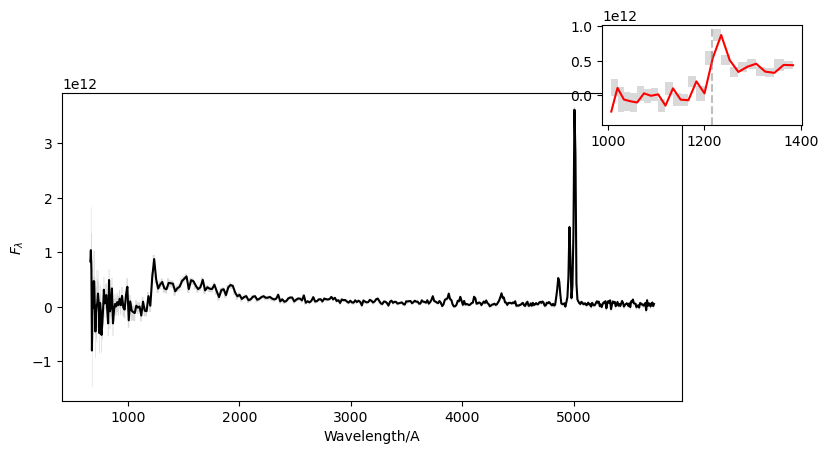

100%|██████████| 5000/5000 [00:01<00:00, 2990.61it/s]


[-3.1058473]
[0.30814347 0.30811963]


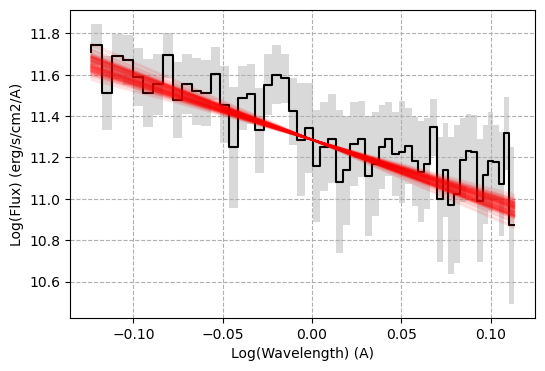

['2426_169_1' '2426_169_2' '2426_169_3' '2426_169_4' '2426_169_5'
 '2426_169_6' '2426_169_7' '2426_169_8' '2426_169_9' '2426_169_10'
 '2426_169_11' '2426_169_12' '2426_169_13' '2426_169_14' '2426_169_15'
 '2426_169_16' '2426_169_17' '2426_169_18' '2426_169_19' '2426_169_20'
 '2426_169_21' '2426_169_22' '2426_169_23' '2426_169_24' '2426_169_25'
 '2426_169_26' '2426_169_27' '2426_169_28' '2426_169_29' '2426_169_30'
 '2426_169_32' '2426_169_33' '2426_169_34' '2426_169_35' '2426_169_36'
 '2426_169_37' '2426_169_38' '2426_169_39' '2426_169_40' '2426_169_41'
 '2426_169_42' '2426_169_43' '2426_169_44' '2426_169_45' '2426_169_46'
 '2426_169_47' '2426_169_48' '2426_169_49' '2426_169_50' '2426_169_51'
 '2426_169_52' '2426_169_53' '2426_169_54' '2426_169_55' '2426_169_56'
 '2426_169_57' '2426_169_58' '2426_169_59' '2426_169_60' '2426_169_61'
 '2426_169_62' '2426_169_63']
2426_169
2426_169_1
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  Tr

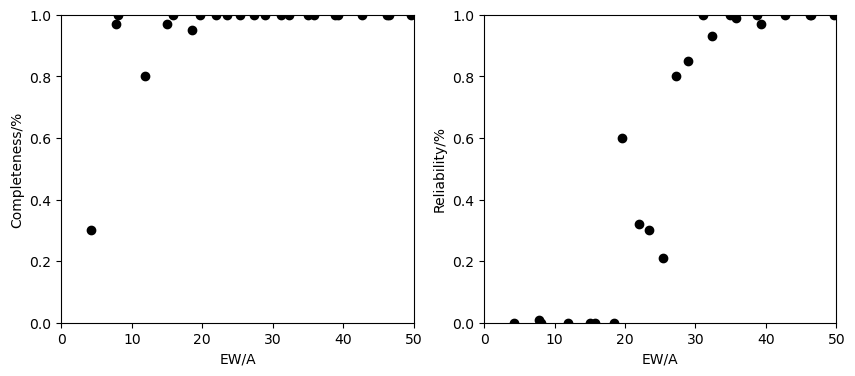

/Users/lucas/Library/CloudStorage/OneDrive-Personal/University work/NeutralHydrogen/JWSTConvolution.py:22: RuntimeWarning: invalid value encountered in sqrt
  sigma_lambda = np.sqrt((lam_obs / R_high) ** 2 - delta_wl_high.mean() ** 2)


Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to database
Synthetic spectra added to d

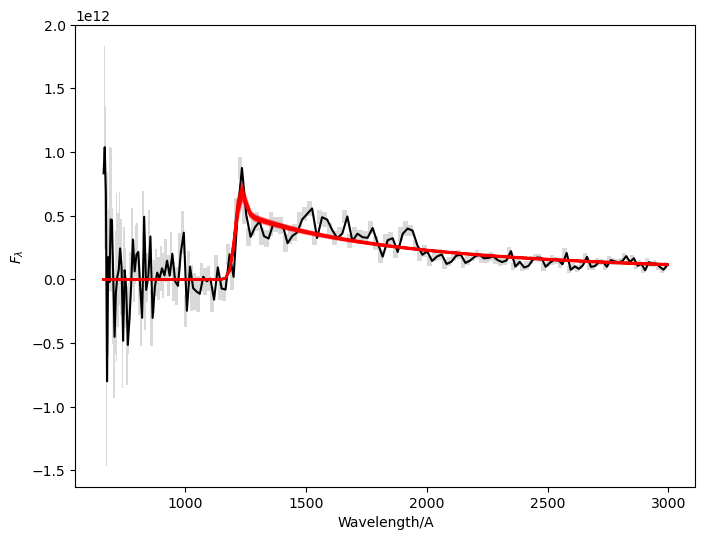

Lyman Alpha EW: 57.130354748764375 ± 8.50867796761778 A


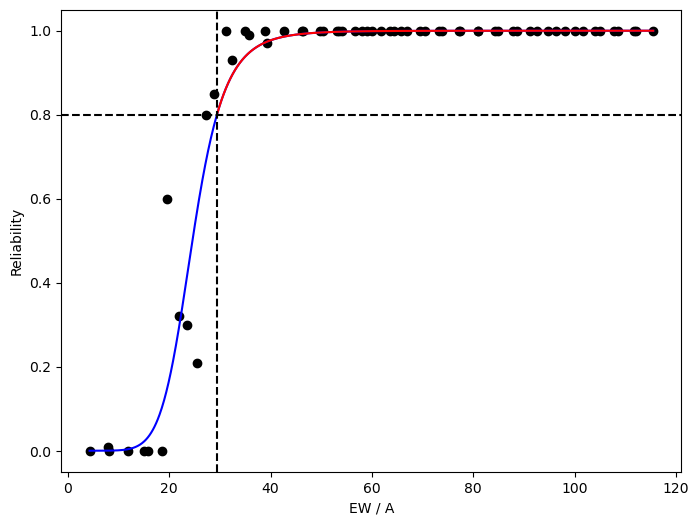

29.394462724951058


In [64]:
source = galaxy('2426_169')
source.convert_units()
source.plot_spectrum()
source.beta_fitting()
#source.recombine_spectra(sdss)
#source.get_mag_f150W(RA_List, DEC_List, Mag_List)
#source.generate_simulated_spectra(convolution_curve_wavelength, convolution_curve_resolution)
source.calculate_completeness_reliability()
source.plot_completeness_reliability()
source.fit_lyman_alpha(100)
source.calculate_lyman_alpha()
source.find_completness_limts()


In [7]:
class pipeline:
    def __init__(self, jewels):
        self.sources = [galaxy(msaid) for msaid in jewels.tab['msaid']]
        self.borg_sources = []
        for source in jewels.tab:
            if source['survey'] == 'borg':
                self.borg_sources.append(galaxy(source['msaid']))
        for source in self.borg_sources:
            source.convert_units()
            #source.plot_spectrum()

    def test_fitting(self):
        for source in self.borg_sources:
            source.beta_fitting()
            source.generate_simulated_spectra(convolution_curve_wavelength, convolution_curve_resolution)
            source.calculate_completeness_reliability()
            source.plot_completeness_reliability()

    def plot_completeness_graphs(self):
        for source in self.borg_sources:
            source.calculate_completeness_reliability()
            source.plot_completeness_reliability()

    def beta_fitting(self):
        for source in self.borg_sources:
            source.beta_fitting()

MSAID=1180_134422 z=8.377 ra=53.18338 dec=-27.77017
MSAID=1180_5173 z=7.981 ra=53.15684 dec=-27.76715
MSAID=1180_12637 z=7.663 ra=53.13347 dec=-27.76037
MSAID=1180_13908 z=7.629 ra=53.15544 dec=-27.75609
MSAID=1180_17038 z=7.575 ra=53.08722 dec=-27.77706
MSAID=1180_135134 z=7.438 ra=53.18148 dec=-27.76950
MSAID=1180_13552 z=7.433 ra=53.18346 dec=-27.79099
MSAID=1180_30141745 z=7.286 ra=53.18012 dec=-27.77144
MSAID=1180_9315 z=7.284 ra=53.15509 dec=-27.80177
MSAID=1180_30147912 z=7.278 ra=53.18628 dec=-27.77904
MSAID=1180_13173 z=7.270 ra=53.18396 dec=-27.80000
MSAID=1180_2958 z=7.268 ra=53.18368 dec=-27.79395
MSAID=1180_30139499 z=7.248 ra=53.19415 dec=-27.76838
MSAID=1180_30141478 z=7.244 ra=53.18674 dec=-27.77064
MSAID=1180_15423 z=7.244 ra=53.16959 dec=-27.73805
MSAID=1180_30142600 z=7.242 ra=53.16555 dec=-27.77267
MSAID=1180_30099449 z=7.241 ra=53.16171 dec=-27.78539
MSAID=1180_11547 z=7.241 ra=53.16483 dec=-27.78826
MSAID=1180_9886 z=7.238 ra=53.16556 dec=-27.77266
MSAID=1180_9942

MSAID=1180_7786 z=5.942 ra=53.15219 dec=-27.77840
MSAID=1180_4396 z=5.941 ra=53.13838 dec=-27.77876
MSAID=1180_13612 z=5.940 ra=53.14506 dec=-27.76278
MSAID=1180_9697 z=5.932 ra=53.13044 dec=-27.80236
MSAID=1180_17213 z=5.932 ra=53.16192 dec=-27.73993
MSAID=1180_5438 z=5.929 ra=53.15216 dec=-27.76818
MSAID=1180_9833 z=5.927 ra=53.14208 dec=-27.77985
MSAID=1180_16431 z=5.923 ra=53.10547 dec=-27.76115
MSAID=1180_13620 z=5.920 ra=53.12259 dec=-27.76057
MSAID=1180_13651 z=5.920 ra=53.14987 dec=-27.75283
MSAID=1180_9860 z=5.918 ra=53.16773 dec=-27.76816
MSAID=1180_12336 z=5.917 ra=53.16233 dec=-27.76687
MSAID=1180_9365 z=5.916 ra=53.16280 dec=-27.76084
MSAID=1180_9698 z=5.912 ra=53.14077 dec=-27.80218
MSAID=1180_13347 z=5.893 ra=53.20299 dec=-27.77613
MSAID=1180_131737 z=5.892 ra=53.19904 dec=-27.77258
MSAID=1180_9696 z=5.864 ra=53.17752 dec=-27.80252
MSAID=1180_5909 z=5.862 ra=53.18395 dec=-27.80760
MSAID=1180_17224 z=5.851 ra=53.13159 dec=-27.73881
MSAID=1180_5356 z=5.831 ra=53.17988 dec=

/var/folders/0c/mrvrtsyn45lc3bl1_sf8pkdh0000gn/T/ipykernel_97553/339293454.py:13: RuntimeWarning: invalid value encountered in divide
  percentage_error = self.flux_err/self.flux


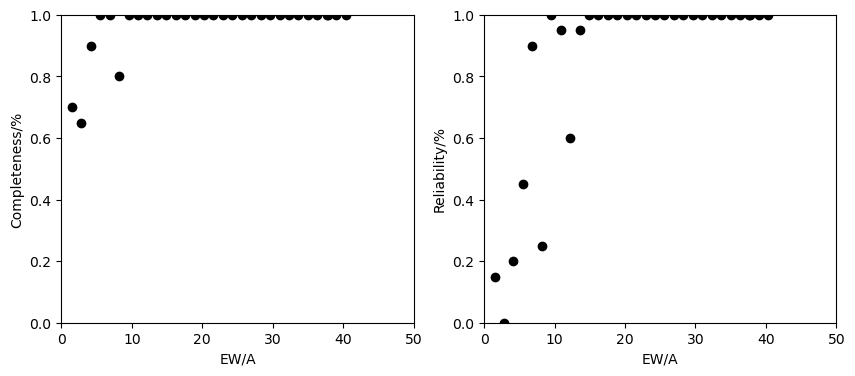

['1747_732_1' '1747_732_2' '1747_732_3' '1747_732_4' '1747_732_5'
 '1747_732_6' '1747_732_7' '1747_732_8' '1747_732_9' '1747_732_10'
 '1747_732_11' '1747_732_12' '1747_732_13' '1747_732_14' '1747_732_15'
 '1747_732_16' '1747_732_17' '1747_732_18' '1747_732_19' '1747_732_20'
 '1747_732_21' '1747_732_22' '1747_732_23' '1747_732_24' '1747_732_25'
 '1747_732_26' '1747_732_27' '1747_732_28' '1747_732_29' '1747_732_30'
 '1747_732_31' '1747_732_32' '1747_732_33']
1747_732
1747_732_1
[False False False False False False False False False False False False
 False False  True False False False False False]
1747_732_2
[ True  True False  True False False  True  True  True False  True  True
 False False  True  True False  True False  True]
1747_732_3
[ True  True False  True  True False False False  True  True False  True
 False False False False False  True  True  True]
1747_732_4
[ True  True  True  True  True  True  True  True False  True  True  True
  True False  True  True  True  True  True  

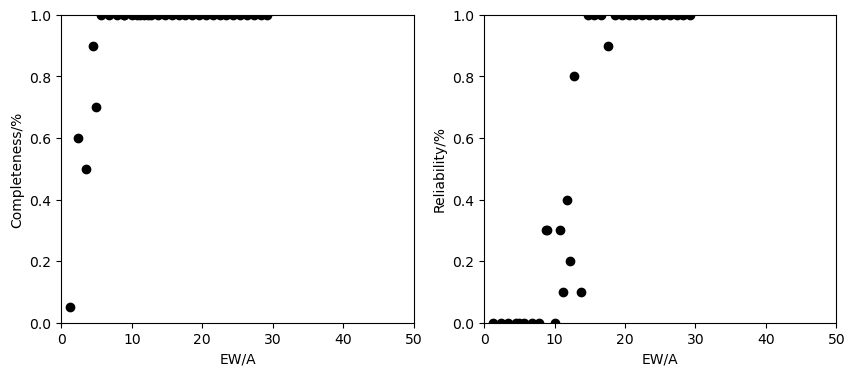

['1747_902_1' '1747_902_2' '1747_902_3' '1747_902_4' '1747_902_5'
 '1747_902_6' '1747_902_7' '1747_902_8' '1747_902_9' '1747_902_10'
 '1747_902_11' '1747_902_12' '1747_902_13' '1747_902_14' '1747_902_15'
 '1747_902_16' '1747_902_17' '1747_902_18' '1747_902_19' '1747_902_20'
 '1747_902_21' '1747_902_22' '1747_902_23' '1747_902_24' '1747_902_25'
 '1747_902_26' '1747_902_27' '1747_902_28' '1747_902_29' '1747_902_30']
1747_902
1747_902_1
[ True  True  True  True  True  True  True  True  True  True]
1747_902_2
[ True  True  True  True  True  True  True  True  True  True]
1747_902_3
[ True  True  True  True  True  True  True  True  True  True]
1747_902_4
[ True  True  True  True  True  True  True  True  True  True]
1747_902_5
[ True  True  True  True  True  True  True  True  True  True]
1747_902_6
[ True  True  True  True  True  True  True  True  True  True]
1747_902_7
[ True  True  True  True  True  True  True  True  True  True]
1747_902_8
[ True  True  True  True  True  True  True  True  T

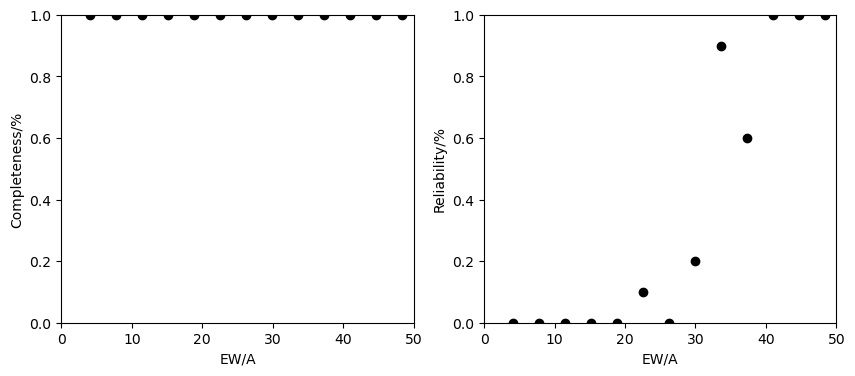

['1747_1081_1' '1747_1081_2' '1747_1081_3' '1747_1081_4' '1747_1081_5'
 '1747_1081_6' '1747_1081_7' '1747_1081_8' '1747_1081_9' '1747_1081_10'
 '1747_1081_11' '1747_1081_12' '1747_1081_13' '1747_1081_14'
 '1747_1081_15' '1747_1081_16' '1747_1081_17' '1747_1081_18'
 '1747_1081_19' '1747_1081_20' '1747_1081_21' '1747_1081_22'
 '1747_1081_23' '1747_1081_24' '1747_1081_25' '1747_1081_26'
 '1747_1081_27' '1747_1081_28' '1747_1081_29' '1747_1081_30']
1747_1081
1747_1081_1
[False  True False False  True False False False  True False]
1747_1081_2
[ True  True False  True  True  True  True  True  True  True]
1747_1081_3
[ True  True  True  True  True  True  True  True  True  True]
1747_1081_4
[ True  True False  True False  True False  True  True False]
1747_1081_5
[False  True  True False False False False False False  True]
1747_1081_6
[ True  True  True  True  True  True  True  True  True  True]
1747_1081_7
[ True  True  True  True  True  True  True False False  True]
1747_1081_8
[ True  Tru

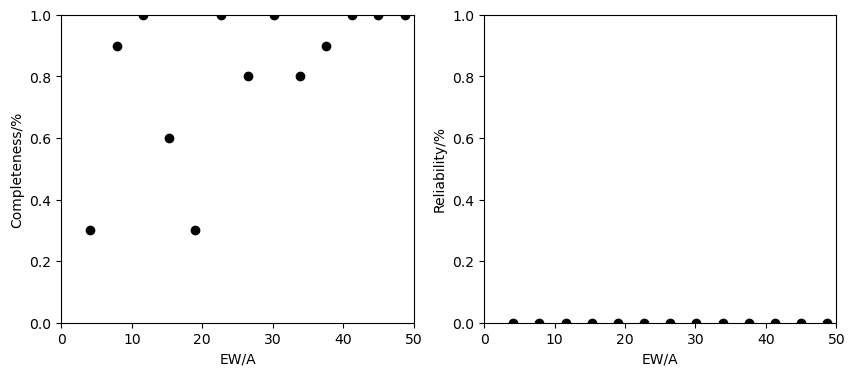

['1747_817_1' '1747_817_2' '1747_817_3' '1747_817_4' '1747_817_5'
 '1747_817_6' '1747_817_7' '1747_817_8' '1747_817_9' '1747_817_10'
 '1747_817_11' '1747_817_12' '1747_817_13' '1747_817_14' '1747_817_15'
 '1747_817_16' '1747_817_17' '1747_817_18' '1747_817_19' '1747_817_20'
 '1747_817_21' '1747_817_22' '1747_817_23' '1747_817_24' '1747_817_25'
 '1747_817_26' '1747_817_27' '1747_817_28' '1747_817_29' '1747_817_30']
1747_817
1747_817_1
[ True False  True  True  True  True  True  True  True  True]
1747_817_2
[ True  True  True  True  True  True  True  True  True  True]
1747_817_3
[ True  True  True  True False  True  True  True  True  True]
1747_817_4
[ True  True  True  True  True  True  True  True  True  True]
1747_817_5
[ True  True  True  True  True  True  True  True  True  True]
1747_817_6
[ True  True  True  True  True  True  True  True  True  True]
1747_817_7
[ True  True  True  True  True  True  True  True  True  True]
1747_817_8
[ True  True  True  True  True  True  True  True  T

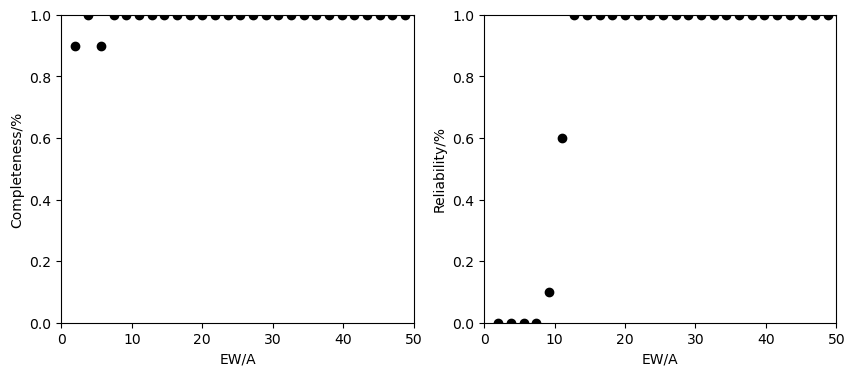

['1747_1425_1' '1747_1425_2' '1747_1425_3' '1747_1425_4' '1747_1425_5'
 '1747_1425_6' '1747_1425_7' '1747_1425_8' '1747_1425_9' '1747_1425_10'
 '1747_1425_11' '1747_1425_12' '1747_1425_13' '1747_1425_14'
 '1747_1425_15' '1747_1425_16' '1747_1425_17' '1747_1425_18'
 '1747_1425_19' '1747_1425_20' '1747_1425_21' '1747_1425_22'
 '1747_1425_23' '1747_1425_24' '1747_1425_25' '1747_1425_26'
 '1747_1425_27' '1747_1425_28' '1747_1425_29' '1747_1425_30']
1747_1425
1747_1425_1
[ True False  True False  True  True  True False  True  True]
1747_1425_2
[ True  True  True  True  True  True  True  True  True  True]
1747_1425_3
[ True  True  True  True  True  True False  True  True  True]
1747_1425_4
[ True  True  True False  True  True  True  True False  True]
1747_1425_5
[ True  True  True  True  True  True  True  True  True  True]
1747_1425_6
[ True  True  True  True  True  True  True  True  True  True]
1747_1425_7
[ True  True  True  True  True  True  True  True  True  True]
1747_1425_8
[ True  Tru

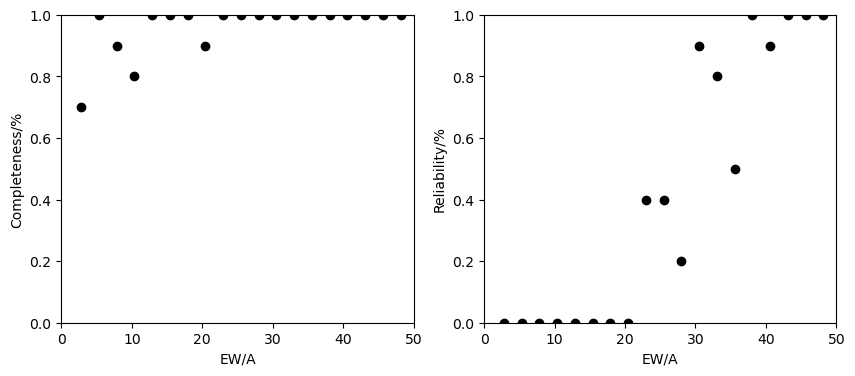

['1747_138_1' '1747_138_2' '1747_138_3' '1747_138_4' '1747_138_5'
 '1747_138_6' '1747_138_7' '1747_138_8' '1747_138_9' '1747_138_10'
 '1747_138_11' '1747_138_12' '1747_138_13' '1747_138_14' '1747_138_15'
 '1747_138_16' '1747_138_17' '1747_138_18' '1747_138_19' '1747_138_20'
 '1747_138_21' '1747_138_22' '1747_138_23' '1747_138_24' '1747_138_25'
 '1747_138_26' '1747_138_27' '1747_138_28' '1747_138_29' '1747_138_30']
1747_138
1747_138_1
[ True  True  True  True  True  True  True  True  True  True]
1747_138_2
[ True  True  True  True  True  True  True  True  True  True]
1747_138_3
[False False False  True  True  True  True  True  True  True]
1747_138_4
[ True False False False False False False False False False]
1747_138_5
[ True  True  True  True  True  True False  True  True  True]
1747_138_6
[ True  True  True  True  True  True  True  True  True  True]
1747_138_7
[False  True  True  True False  True  True  True False False]
1747_138_8
[ True  True  True  True  True  True  True  True  T

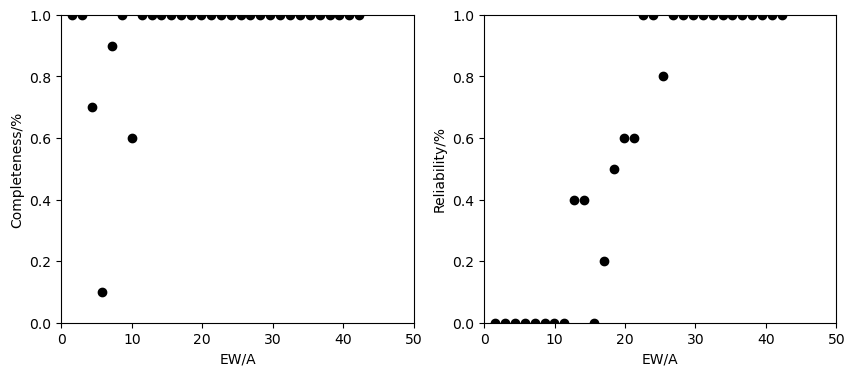

[]
1747_m5
[]


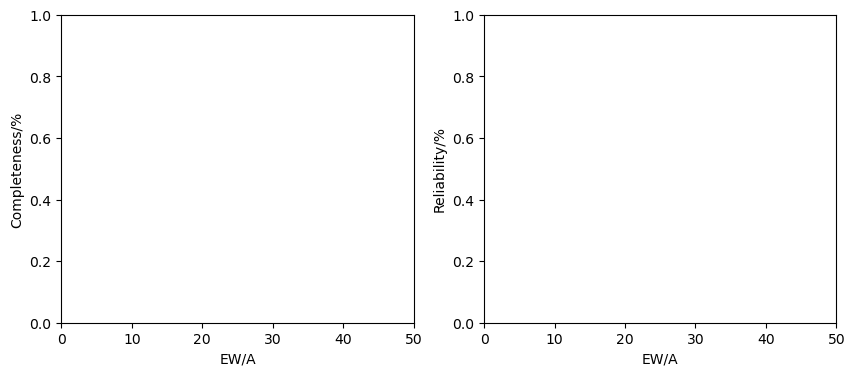

[]
1747_587
[]


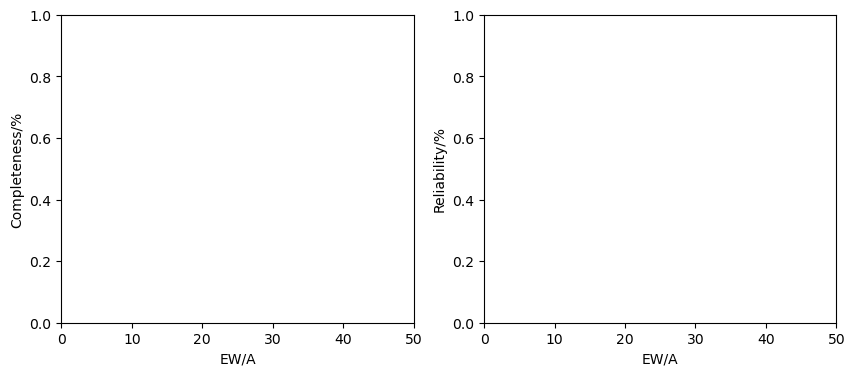

[]
1747_1084
[]


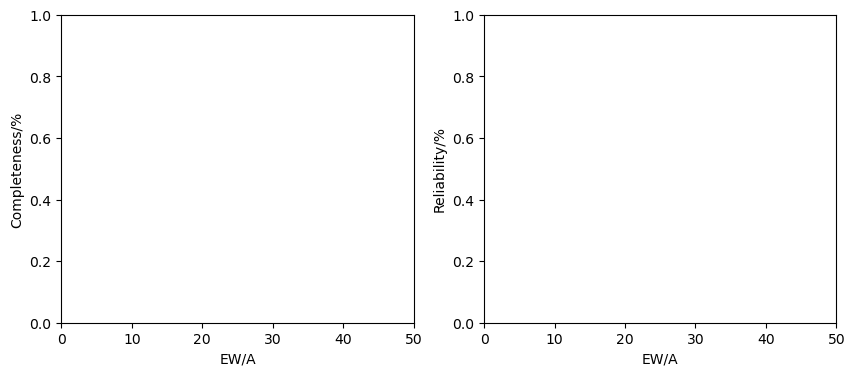

[]
1747_269
[]


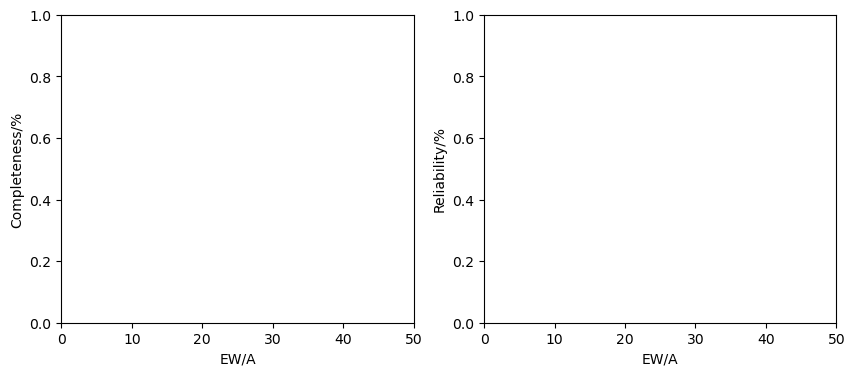

[]
1747_528
[]


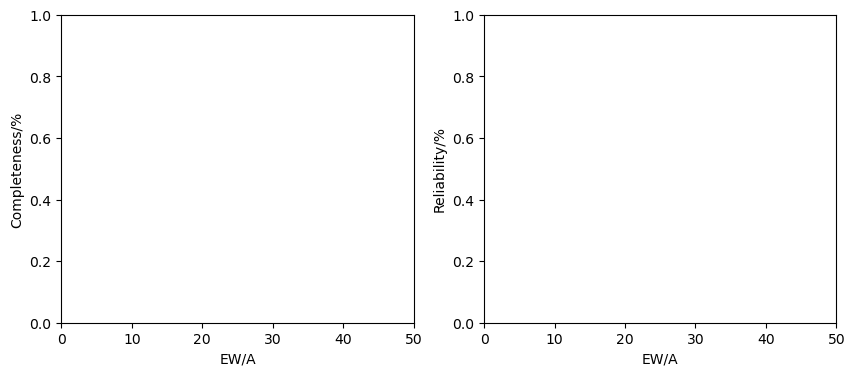

[]
1747_1257
[]


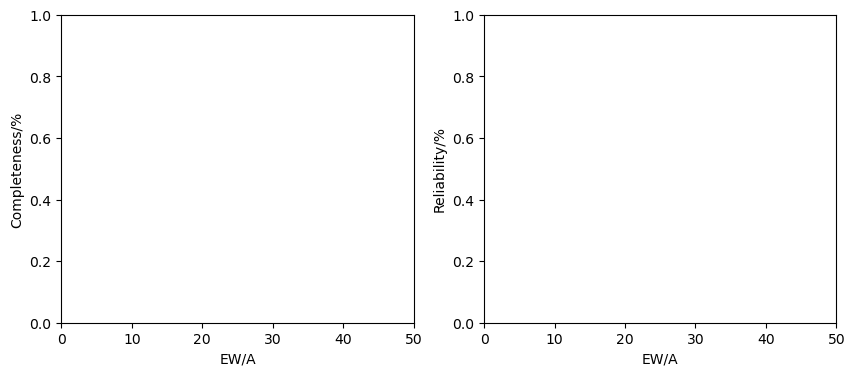

[]
1747_412
[]


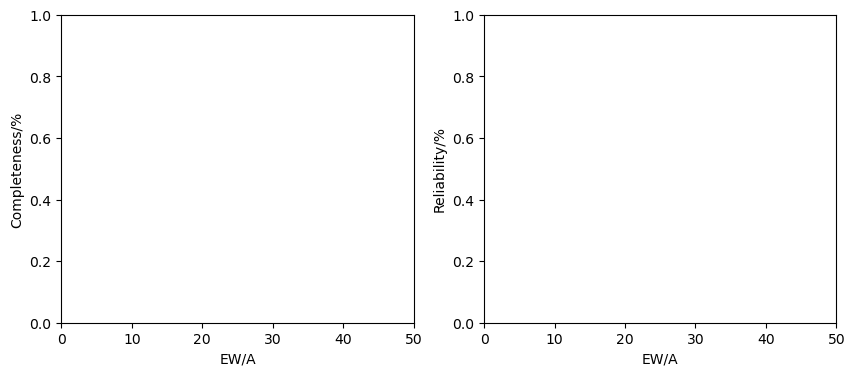

[]
2426_1130
[]


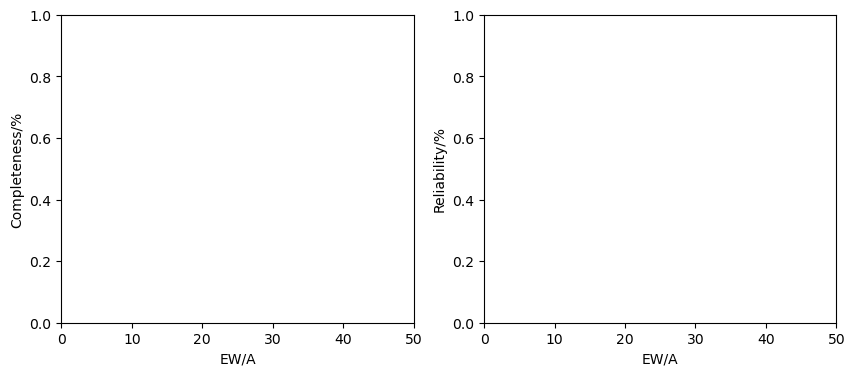

[]
2426_1777
[]


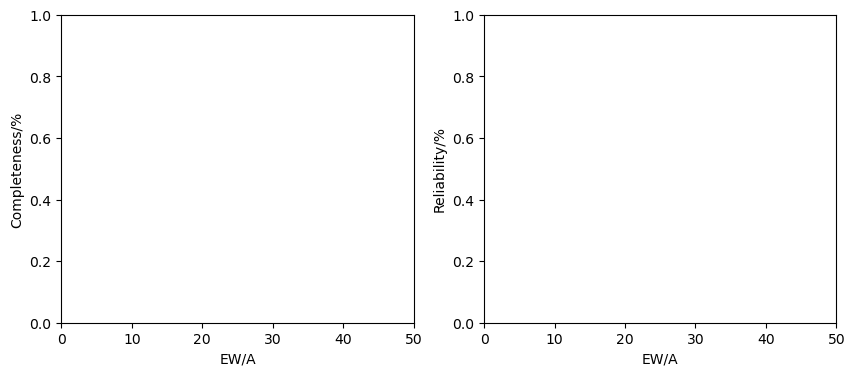

['2426_169_1' '2426_169_2' '2426_169_3' '2426_169_4' '2426_169_5'
 '2426_169_6' '2426_169_7' '2426_169_8' '2426_169_9' '2426_169_10'
 '2426_169_11' '2426_169_12' '2426_169_13' '2426_169_14' '2426_169_15'
 '2426_169_16' '2426_169_17' '2426_169_18' '2426_169_19' '2426_169_20'
 '2426_169_21' '2426_169_22' '2426_169_23' '2426_169_24' '2426_169_25'
 '2426_169_26' '2426_169_27' '2426_169_28' '2426_169_29' '2426_169_30'
 '2426_169_32' '2426_169_33' '2426_169_34' '2426_169_35' '2426_169_36'
 '2426_169_37' '2426_169_38' '2426_169_39' '2426_169_40' '2426_169_41'
 '2426_169_42' '2426_169_43' '2426_169_44' '2426_169_45' '2426_169_46'
 '2426_169_47' '2426_169_48' '2426_169_49' '2426_169_50' '2426_169_51'
 '2426_169_52' '2426_169_53' '2426_169_54' '2426_169_55' '2426_169_56'
 '2426_169_57' '2426_169_58' '2426_169_59' '2426_169_60' '2426_169_61'
 '2426_169_62' '2426_169_63']
2426_169
2426_169_1
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  Tr

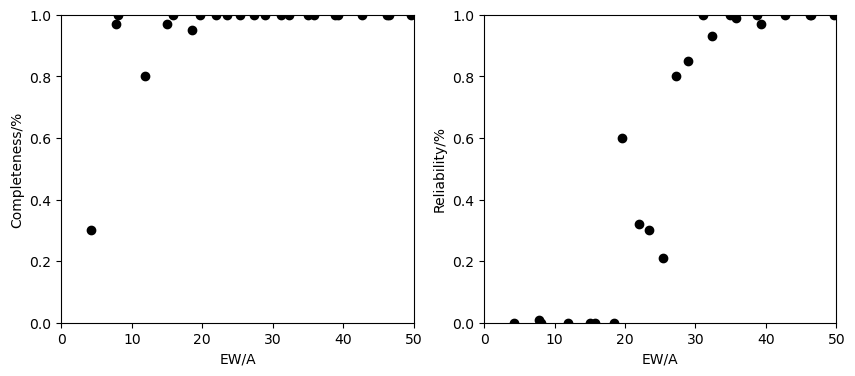

[]
2426_1690
[]


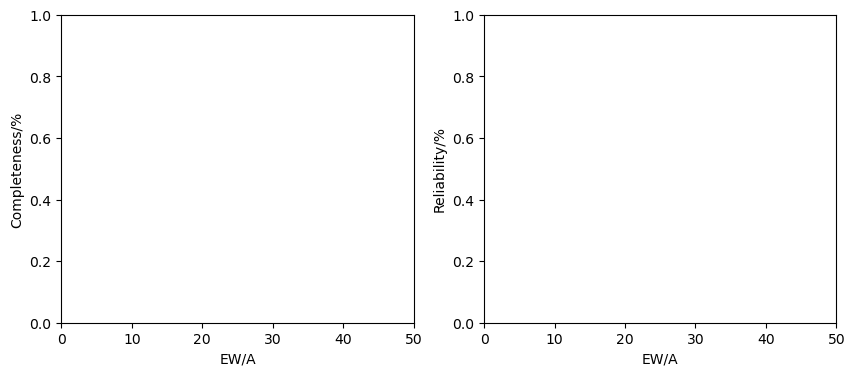

[]
2426_1655
[]


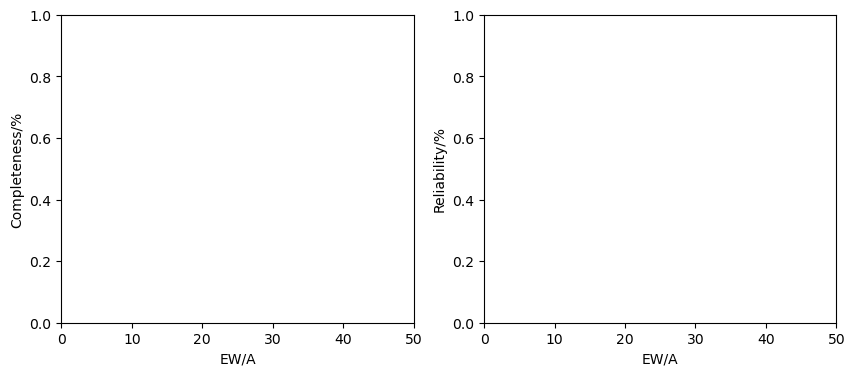

[]
2426_1736
[]


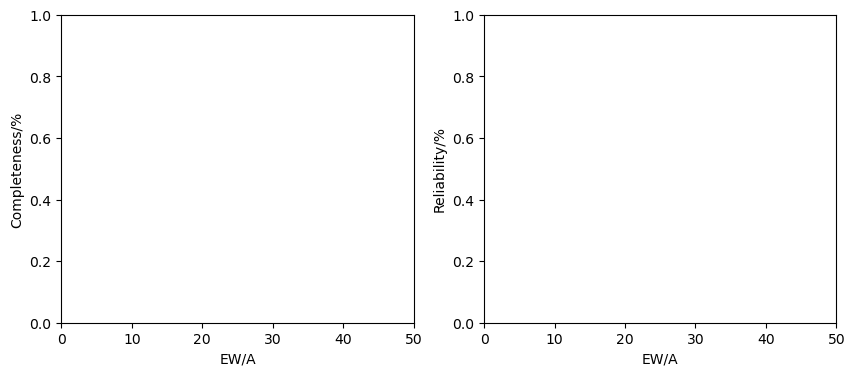

[]
2426_112
[]


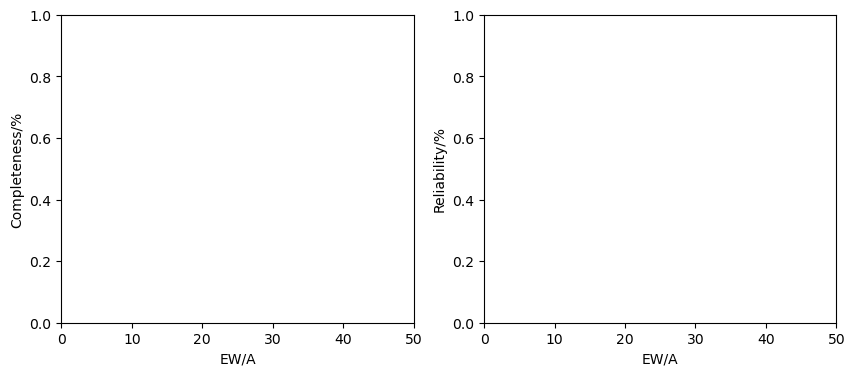

In [8]:
main = pipeline(jewels)
#main.test_fitting()
main.plot_completeness_graphs()